In [ ]:
#  Homelessness Definitions.ipynb - Analyzes different tests for emergency shelter access.
#     Copyright (C) 2020  Geoffrey G. Messier
# 
#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.
# 
#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.
# 
#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sci
import scipy.special as scisp
import scipy.stats as scist
import datetime, copy, imp, sys

sys.path.append('../../lib')

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import kmeans as km

tqdm.pandas()
plt.ion()

### Pre-Process Data

In [2]:
tblAll = pd.read_hdf('~/data/plwh/UniversityExportAnonymized.hd5')

In [3]:
tblAll = tblAll[tblAll.EntryType == 'Sleep'][ ['Date','ClientId'] ]
tblAll.dtypes

Date        datetime64[ns]
ClientId             int64
dtype: object

### Remove Censoring Bias
- Discard all clients who register within a 2 year window of the start and end of the data.

In [4]:
# Registration date is the first date a client shows up in the data.
def find_registration_date(tbl):
    return min(tbl.Date)

regDates = tblAll.groupby('ClientId').progress_apply(find_registration_date)

100%|██████████| 34577/34577 [00:13<00:00, 2580.95it/s]


In [5]:
# These cutoff values remove left and right censoring bias, as disucssed in the paper.
leftCutoff = pd.to_datetime('2009-07-01')
rightCutoff = pd.to_datetime('2018-01-06')

nClientsAll = len(regDates)
validClientInd = (regDates >= leftCutoff) & (regDates <= rightCutoff)
nClients = sum(validClientInd)

print('Original Clients: %d, Valid Clients: %d (%.1f%%)' % (nClientsAll,nClients,100*nClients/nClientsAll))

Original Clients: 34577, Valid Clients: 18346 (53.1%)


In [6]:
# Include only valid clients that meet the left/right censoring cutoff criteria.
tbl = tblAll.loc[list(validClientInd[tblAll.ClientId])]

### Identify Episodes and Stays

In [7]:
# Create a table where stays are sorted in chronological order for each client.
def gen_stay_dates(tbl):
    dates = tbl.Date.drop_duplicates().sort_values()
    return pd.DataFrame({
        'Date': dates,                 # Date of each stay.
        'Ind': range(1,len(dates)+1)   # Index of each stay.
    })
        
stays = tbl.groupby('ClientId').progress_apply(gen_stay_dates)    

100%|██████████| 18346/18346 [00:34<00:00, 530.13it/s]


In [8]:
# Create a table where episodes are sorted in chronological order for each client.
episodeGap = 30  # The max gap in stays before a new episode is created.

def gen_episode_dates(tbl):    
    stayDates = tbl.Date.drop_duplicates().sort_values()
    gapVals = stayDates.diff().astype('timedelta64[D]')
    gapInd = (gapVals >= episodeGap).astype('int').cumsum().drop_duplicates(keep='first')
    
    return pd.DataFrame({
        'Date': tbl.loc[gapInd.index].Date, # Date of first day of each episode.
        'Ind': range(1,len(gapInd)+1)       # Episode index.
    })
    
epis = tbl.groupby('ClientId').progress_apply(gen_episode_dates)

100%|██████████| 18346/18346 [01:18<00:00, 233.78it/s]


In [9]:
# Determine the total number of stays and episodes for each client and store in seDat.
clientInds = stays.index.get_level_values(0).drop_duplicates()
seDat = pd.DataFrame({ 
    'nSty': [0]*nClients,   # Stores total stays.
    'nEpi': [0]*nClients }, # Stores total episodes.
    index=clientInds)
for id in tqdm(clientInds):
    seDat.loc[id,'nSty'] = stays.loc[id].Ind.max() # Number of stays is max stay index.
    seDat.loc[id,'nEpi'] = epis.loc[id].Ind.max()  # Number of episodes is max episode index.

100%|██████████| 18346/18346 [01:11<00:00, 256.04it/s]


In [10]:
# Determine the number of new clients that register per month.
regDates = list(tbl.groupby('ClientId').Date.min())  # List of first dates that each client appears.

# Resample the dates to determine how many new registrants we have per month.
monthlyReg = pd.DataFrame([1]*nClients,index=regDates).groupby(pd.Grouper(freq='M')).count()

print('New Clients per Month - Mean: %g, Median: %g' % (monthlyReg.mean(),monthlyReg.median()))

New Clients per Month - Mean: 178.117, Median: 172


### Joint Distribution
- This is a histogram that illustrates how many clients (shown by the vertical axis) have a particular number of shelter stays and episodes.

In [11]:
stayMax = 2000  # Max range of histogram.
episodeMax = 20
nS = np.arange(0,stayMax,200)  # Variables holding the bins for number of stays and episodes.
nE = np.arange(0,episodeMax,2)
H, xEdge, yEdge = np.histogram2d(seDat.nEpi,seDat.nSty,bins=(nE,nS))

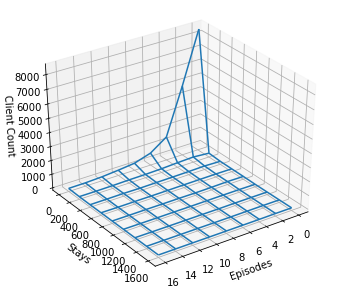

In [12]:
fig = plt.figure(figsize=(6,5))
ax = fig.gca(projection='3d')
x,y = np.meshgrid(xEdge[:-1],yEdge[:-1],indexing='ij')

ax.plot_wireframe(x,y,H)
ax.set_ylabel('Stays')
ax.set_xlabel('Episodes')
ax.set_zlabel('Client Count')
ax.view_init(34,55)

#plt.savefig('JointHist.eps')
plt.show()

### Perform Cluster Analysis

In [13]:
k = 3  # Established in previous work to yield the transitional, chronic and episodic clusters.

cluster = km.KMeansCluster(k,seDat)
(mus,clstrAsgn,pTable) = cluster.Solve(40,0.005)

# The cluster indices representing chronic, episodic and transitional can change from run to
# run due to how the cluster analysis is randomly initialized.  This code determines those indices.
chrId = np.argmax(mus[:,0])  # Chronic clients have the highest number of stays.
epiId = np.argmax(mus[:,1])  # Episodic clients have the highest number of episodes.
tmpId = list( set([0,1,2]) - set([chrId,epiId]) )[0]  # Transitional clients are the group left over.
styMuInd = 0
epiMuInd = 1

pTable

,i,j,pVal
0,0,1,1.110223e-16
1,0,2,1.110223e-16
2,1,2,1.110223e-16


In [14]:
# Calculate statistics on the three clusters to compare to previously published results.

tmpN = sum(clstrAsgn == tmpId)  # Total number of clients in each group.
chrN = sum(clstrAsgn == chrId)
epiN = sum(clstrAsgn == epiId)

print('Trans (%d/%d, %.1f%%) > AvgStays: %g, AvgEpisodes: %g, ' 
      % (tmpN,nClients,100*tmpN/nClients,mus[tmpId,styMuInd],mus[tmpId,epiMuInd]))
print('Epi   (%d/%d, %.1f%%) > AvgStays: %g, AvgEpisodes: %g, ' 
      % (epiN,nClients,100*epiN/nClients,mus[epiId,styMuInd],mus[epiId,epiMuInd]))
print('Chron (%d/%d, %.1f%%) > AvgStays: %g, AvgEpisodes: %g, ' 
      % (chrN,nClients,100*chrN/nClients,mus[chrId,styMuInd],mus[chrId,epiMuInd]))

print('Max stays for single episode transitional client: ',
      seDat[(clstrAsgn == tmpId) & (seDat.nEpi == 1)].nSty.max())

Trans (15623/18346, 85.2%) > AvgStays: 30.2765, AvgEpisodes: 1.81738, 
Epi   (2185/18346, 11.9%) > AvgStays: 166.947, AvgEpisodes: 9.19451, 
Chron (538/18346, 2.9%) > AvgStays: 1274.2, AvgEpisodes: 3.66357, 
Max stays for single episode transitional client:  665


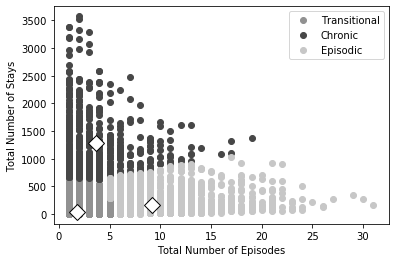

In [15]:
%matplotlib inline
fig = plt.figure()
plt.plot(seDat[clstrAsgn==tmpId].nEpi,seDat[clstrAsgn==tmpId].nSty,color='#919191',marker='o',
         ls='None',label='Transitional')
plt.plot(seDat[clstrAsgn==chrId].nEpi,seDat[clstrAsgn==chrId].nSty,color='#474747',marker='o',
         ls='None',label='Chronic')
plt.plot(seDat[clstrAsgn==epiId].nEpi,seDat[clstrAsgn==epiId].nSty,color='#c7c7c7',marker='o',
         ls='None',label='Episodic')
plt.plot([ mus[tmpId,epiMuInd], mus[epiId,epiMuInd],mus[chrId,epiMuInd] ],
         [ mus[tmpId,styMuInd], mus[epiId,styMuInd],mus[chrId,styMuInd] ],
         'kD',markerfacecolor='white',markersize=12)
plt.xlabel('Total Number of Episodes')
plt.ylabel('Total Number of Stays')
plt.legend()
#plt.savefig('ClusterResults.eps')
plt.show()

### Support Routines
- The same bits of code we're running over and over again.

In [16]:
# When combining two tests for classifying shelter stays (eg. an episode count test and a stay count test),
# we use this function to choose between the two based on which one is satisfied earliest.
def choose_earliest(one,two):
    nRec = len(one.index)
    
    # Create a blank table where all clients are intially transient.  
    tbl = pd.DataFrame({ 'Flag': ['tmp']*nRec, 'Date': [pd.NaT]*nRec, 'Time': [np.nan]*nRec },index=one.index)
    
    # All clients that are either just classified in 'one' or are classified first in 'one'.
    isOne = (one.Flag!='tmp') & (two.Flag=='tmp') | ((one.Flag!='tmp') & (two.Flag!='tmp') & (one.Time<two.Time))
    tbl[isOne] = one[isOne]
    
    # All clients are are either just classified in 'two' or are classified first in 'two'.
    isTwo = (one.Flag=='tmp') & (two.Flag!='tmp') | ((one.Flag!='tmp') & (two.Flag!='tmp') & (one.Time>=two.Time))
    tbl[isTwo] = two[isTwo]
    
    return tbl

In [17]:
# Checks for clients are are 'continually homeless' for a threshold number of days.
# - We define this as having an episode of homelessness longer than the threshold.
def continually_homeless(tbl,flagStr,reqDuration):

    gapVals = tbl.Date.diff().astype('timedelta64[D]')  # Gaps are the difference between access dates.
    
    # Give each episode of shelter accesses a unique index number.
    gapInd = (gapVals >= episodeGap).astype('int').cumsum() 

    for iGap in range(max(gapInd)+1):
        startDate = tbl[gapInd==iGap].Date.min()
        endDate = tbl[gapInd==iGap].Date.max()
        curDuration = (endDate - startDate).days + 1

        if curDuration > reqDuration:           
            # Find first date the client's episode exceeded the threshold.
            idDate = tbl[(tbl.Date - startDate).dt.days >= reqDuration].Date.min()
            
            epiStartDate = tbl[gapInd==iGap].Date.iloc[0]
            overMaxStays = (tbl.Date - epiStartDate).dt.days >= reqDuration
            
            return pd.Series({
                'Flag': flagStr,  # Flag indicating test was satisfied.
                'Date': idDate,   # Date client satisfied the test.
                'Time': (idDate - startDate).days  # How long it took to satisfy the test.
            })            
    
    # Returned if client doesn't satisfy the test.
    return pd.Series({
        'Flag': 'tmp',
        'Date': pd.NaT,
        'Time': np.nan
    })

# Function test:
#continually_homeless(stays.loc[21910],'cnt',365)  

In [18]:
# Applies a non-windowed threshold test to a count of stays/episodes.
def count_thresh(tbl,flagStr,thresh):

    registrationDate = tbl.Date.min()
    idDate = tbl[tbl.Ind >= thresh].Date.min()  # Will be equal to NaN if the threshold isn't met.

    if idDate == idDate:   # Satisfied if idDate is not NaN.
        return pd.Series({
            'Flag': flagStr,  # Flag indicating test was satisfied.
            'Date': idDate,   # Date client was identified.
            'Time': (idDate - registrationDate).days  # Number of days it took to identify client.
        })
    else:
        return pd.Series({   # Returned if the test is not satisfied.
            'Flag': 'tmp',
            'Date': pd.NaT,
            'Time': np.nan
        })

# Function test:    
#count_thresh(stays.loc[9621],'stay',3) 
#count_thresh(epis.loc[2498702],'epi',3) 

In [19]:
# Applies a time windowed threshold test to either a count of episodes or stays.
def count_thresh_win(tbl,flagStr,thresh,winSz):
    
    # Apply a rolling time window of 'winSz' days on the count of episodes/stays.
    win = tbl.rolling('%dd' % winSz,on='Date').count().Ind
    
    registrationDate = tbl.Date.min()
    idDate = tbl[win >= thresh].Date.min()  # Will be equal to NaN if the threshold isn't met.
    
    if idDate == idDate:   # Satisfied if idDate is not NaN.
        return pd.Series({
            'Flag': flagStr,  # Flag indicating test was satisfied.
            'Date': idDate,   # Date client was identified.
            'Time': (idDate - registrationDate).days  # Number of days it took to identify client.
        })
    else:
        return pd.Series({   # Returned if the test is not satisfied.
            'Flag': 'tmp',
            'Date': pd.NaT,
            'Time': np.nan
        })

# Function test:
#count_thresh_win(epis.loc[2498702],'epi',3,200) 

In [20]:
# Determines the number of shelter stays and days of shelter interaction saved if a client
# identified as chronic or episodic is placed in a house the day they're identified.
def intervention_impact(
    testList,  # Client list after being processed by a shelter stay test.
    stays      # Stay table produced by gen_stay_dates().
    ):   
    
    staysSaved = 0
    daysSaved = 0
    
    # Loop through all clients that are not transitional.
    for clientId in testList[testList.Flag != 'tmp'].index:
        
        # Find the stays that occur after the client is identified
        saved = stays.loc[clientId][stays.loc[clientId].Date >= testList.loc[clientId].Date] 
        
        staysSaved += saved.Ind.count()-1
        daysSaved += (saved.Date.iloc[-1]-testList.loc[clientId].Date).days
    
    nClientsIdentified = sum(testList.Flag != 'tmp')
    return { 'Stays': staysSaved/nClientsIdentified, 'Days': daysSaved/nClientsIdentified }

# Function test
#intervention_impact(sty180L365,stays)

In [21]:
# Calculates shelter access summary statistics for each client.
def summarize_client_access(tbl):
    
    tenure = (tbl.Date.max() - tbl.Date.min()).days + 1
    gapVals = tbl.Date.diff().astype('timedelta64[D]')
    nStays = tbl.Ind.max()
    
    return pd.Series({
        'Tenure': tenure,  # Total span of days a client interacts with shelter.
        'UsagePct': 100.0*nStays/tenure,  # Percentage of days during tenure client stayed in shelter.
        'AvgGapLen': gapVals.mean(),  # Average length of gaps in shelter stays.
        'TotalStays': nStays,  # Total number of shelter stays.
        'TotalEpisodes': sum(gapVals >= episodeGap)+1  # Total number of episodes.
    })

# Function test:
#summarize_client_access(stays.loc[9570])

# Determine access stats for all clients.
access = stays.groupby('ClientId').progress_apply(summarize_client_access)

100%|██████████| 18346/18346 [00:30<00:00, 595.32it/s]


In [22]:
# Helper function that prints out access statistics for a cohort of clients.
def print_stats(tblStr,tbl,fields):
    print('--- %s ---' % (tblStr))
    nEntry = len(tbl.index)
    print( 'Clients in cohort: %d/%d (%.1f%%)' % (nEntry,nClients,100*nEntry/nClients))
    print( 'Size of 10%% of cohort: %d/%d (%.1f%%)' % (nEntry*0.1,nClients,100*nEntry*0.1/nClients))
    for field in fields:
        print('%s:' % (field))
        nEntry = sum(~np.isnan(tbl[field]))        
        
        print(' Avg: %.1f, Med: %.1f, 10thPct: %.1f, 90thPct: %.1f' 
              %(tbl[field].mean(),tbl[field].median(),
                tbl[field].sort_values().iloc[int(nEntry*0.1)],
                tbl[field].sort_values().iloc[int(nEntry*0.9)]))
        
        print('  %.1f & %.1f & %.1f' 
              %(tbl[field].mean(),tbl[field].median(),
                tbl[field].sort_values().iloc[int(nEntry*0.9)]))
        
    print('')

### Basic Definition Operations
- Look at clients that exceed a lifetime count of stays and episodes (no windowing).
- Choose whichever rule is satisfied first for the client.
- The purpose of this section is to establish that counting episodes generally identifies episodic shelter clients while counting stays generally identifies chronic shelter clients.

In [23]:
sty180Linf = stays.groupby('ClientId').apply(count_thresh,flagStr='sty',thresh=180)

In [24]:
epi4Linf = epis.groupby('ClientId').apply(count_thresh,flagStr='epi',thresh=4)

In [25]:
defSmpl = choose_earliest(sty180Linf,epi4Linf)

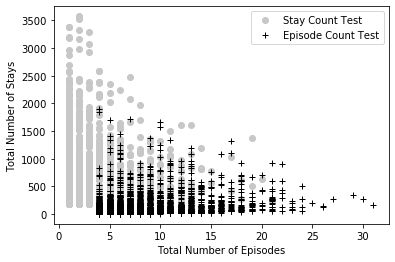

In [60]:
%matplotlib inline
plt.plot(seDat[defSmpl.Flag=='sty'].nEpi,seDat[defSmpl.Flag=='sty'].nSty,
         color='#c7c7c7',marker='o',ls='None',label='Stay Count Test')
plt.plot(seDat[defSmpl.Flag=='epi'].nEpi,seDat[defSmpl.Flag=='epi'].nSty,
         color='black',marker='+',ls='None',label='Episode Count Test')
plt.xlabel('Total Number of Episodes')
plt.ylabel('Total Number of Stays')
plt.legend()
#plt.savefig('BasicOps.eps')
plt.show()

### Lumping vs Separating Chronic & Episodic Clients
- The purpose of this section is to create a plot that shows the Government of Alberta definition lumps episodic and chronic shelter clients into the same group.

#### Government of Alberta
- Continually homeless for $K$ = 365 days or $N$ = 4 episodes of homelessness in $K$ = 365 days.
- Continually homeless refers to the total length of a single episode rather than a sum of stays.

In [27]:
cntL365 = stays.groupby('ClientId').apply(continually_homeless,flagStr='cnt',reqDuration=365)

In [28]:
epi4L365 = epis.groupby('ClientId').apply(count_thresh_win,flagStr='epi',thresh=4,winSz=365)

In [29]:
defGoa = choose_earliest(cntL365,epi4L365)

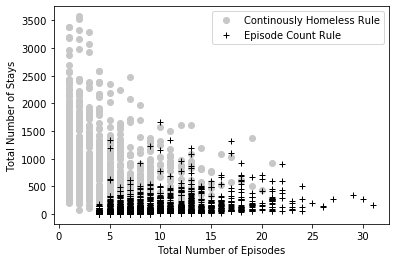

In [62]:
%matplotlib inline
plt.plot(seDat[defGoa.Flag=='cnt'].nEpi,seDat[defGoa.Flag=='cnt'].nSty,
         color='#c7c7c7',marker='o',ls='None',label='Continously Homeless Rule')
plt.plot(seDat[defGoa.Flag=='epi'].nEpi,seDat[defGoa.Flag=='epi'].nSty,
         color='black',marker='+',ls='None',label='Episode Count Rule')
plt.xlabel('Total Number of Episodes')
plt.ylabel('Total Number of Stays')
plt.legend()
#plt.savefig('GoaLump.eps')
plt.show()

### Evaluating Chronic Client Identification
- This section evaluates a number of different tests for identifying chronic shelter users largely based on what is being used in different existing chronic homelessness definitions.

In [31]:
# Based on Government of Canada
sty180L365 = stays.groupby('ClientId').apply(count_thresh_win,flagStr='sty',thresh=180,winSz=365)

In [32]:
# Based on Calgary Drop-In Centre
sty276L365 = stays.groupby('ClientId').apply(count_thresh_win,flagStr='sty',thresh=276,winSz=365)

In [33]:
# Calgary Drop-In Centre without windowing as a simplification.
sty276Linf = stays.groupby('ClientId').apply(count_thresh,flagStr='sty',thresh=276)

In [34]:
# Print the number of clients identified by each test.
def print_coverage(tbl,labelStr):
    print('%s: %d/%d (%.1f%%)' %
          (labelStr,sum(tbl.Flag!='tmp'),len(tbl.index),100*sum(tbl.Flag!='tmp')/len(tbl.index)))
      
print_coverage(sty180L365,'K=180,L=365')
print_coverage(sty276L365,'K=276,L=365')
print_coverage(sty276Linf,'K=276,L=inf')
print_coverage(cntL365,'365 Continuous')      

K=180,L=365: 1545/18346 (8.4%)
K=276,L=365: 884/18346 (4.8%)
K=276,L=inf: 1407/18346 (7.7%)
365 Continuous: 1004/18346 (5.5%)


In [35]:
# Print the days and stays saved by each test.
print('K=180,L=365',intervention_impact(sty180L365,stays))
print('K=276,L=365',intervention_impact(sty276L365,stays))
print('K=276,L=inf',intervention_impact(sty276Linf,stays))
print('365 Continuous',intervention_impact(cntL365,stays))

K=180,L=365 {'Stays': 499.04271844660195, 'Days': 1009.6576051779936}
K=276,L=365 {'Stays': 624.0158371040724, 'Days': 1022.3755656108598}
K=276,L=inf {'Stays': 487.64818763326224, 'Days': 971.5572139303482}
365 Continuous {'Stays': 548.9442231075698, 'Days': 1018.7021912350598}


In [36]:
# Determine the number of clients identified per month by each test.
# - This estimates how much of a new client load each test would place on a housing program.
regSty180L365 = sty180L365[sty180L365.Flag != 'tmp'].groupby(pd.Grouper(key='Date',freq='M')).Flag.count()
regSty276L365 = sty276L365[sty276L365.Flag != 'tmp'].groupby(pd.Grouper(key='Date',freq='M')).Flag.count()
regSty276Linf = sty276Linf[sty276Linf.Flag != 'tmp'].groupby(pd.Grouper(key='Date',freq='M')).Flag.count()
regCntL365 = cntL365[cntL365.Flag != 'tmp'].groupby(pd.Grouper(key='Date',freq='M')).Flag.count()

In [37]:
print('K=180,L=365 Load - Mean: %g, Median: %g' % (regSty180L365.mean(),regSty180L365.median()))
print('K=276,L=365 Load - Mean: %g, Median: %g' % (regSty276L365.mean(),regSty276L365.median()))
print('K=276,L=inf Load - Mean: %g, Median: %g' % (regSty276Linf.mean(),regSty276Linf.median()))
print('365 Continuous Load - Mean: %g, Median: %g' % (regCntL365.mean(),regCntL365.median()))

K=180,L=365 Load - Mean: 12.9832, Median: 13
K=276,L=365 Load - Mean: 7.68696, Median: 7
K=276,L=inf Load - Mean: 12.2348, Median: 12
365 Continuous Load - Mean: 8.88496, Median: 9


### Evaluating Episodic Client Identification
- Examine the clients identified by different tests for episodic shelter access.
- The 4 episode shelter threshold is accepted in the literature and we explore 3 and 5 just to examine sensitivity to changing the threshold value.

In [38]:
epi4L365 = epis.groupby('ClientId').apply(count_thresh_win,flagStr='epi',thresh=4,winSz=365)

In [39]:
epi3L365 = epis.groupby('ClientId').apply(count_thresh_win,flagStr='epi',thresh=3,winSz=365)

In [40]:
epi5L365 = epis.groupby('ClientId').apply(count_thresh_win,flagStr='epi',thresh=5,winSz=365)

In [41]:
epi4Linf = epis.groupby('ClientId').apply(count_thresh,flagStr='epi',thresh=4)

In [42]:
# This Government of Canada test is the only one that uses stay counts to identify episodic clients.
epiGoc = stays.groupby('ClientId').apply(count_thresh_win,flagStr='sty',thresh=546,winSz=1095)

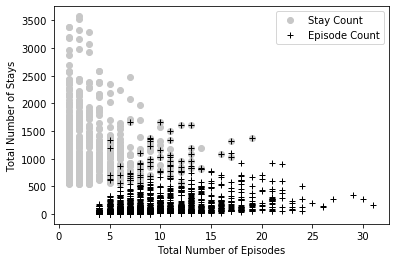

In [66]:
# The purpose of this plot is to demonstrate that the Government of Canada episodic client test mainly 
# still identifies clients with a chronic shelter access pattern.
%matplotlib inline
epiCnt = (epi4L365.Flag == 'epi')  
plt.plot(seDat[epiGoc.Flag=='sty'].nEpi,seDat[epiGoc.Flag=='sty'].nSty,
         color='#c7c7c7',marker='o',ls='None',label='Stay Count')
plt.plot(seDat[epiCnt].nEpi,seDat[epiCnt].nSty,
         color='black',marker='+',ls='None',label='Episode Count')
plt.xlabel('Total Number of Episodes')
plt.ylabel('Total Number of Stays')
plt.legend()
#plt.savefig('EpiStay.eps')
plt.show()

- Since the Government of Canada stay count test identifies mainly chronic clients, only the episode count tests are considered below.
- The same coverage, days/stays saved and load calculations are performed for the episodic results that we used above for the chronic results.

In [44]:
print_coverage(epi3L365,'R=3,L=365')
print_coverage(epi4L365,'R=4,L=365')
print_coverage(epi5L365,'R=5,L=365')
print_coverage(epi4Linf,'R=4,L=inf')

R=3,L=365: 3471/18346 (18.9%)
R=4,L=365: 1580/18346 (8.6%)
R=5,L=365: 617/18346 (3.4%)
R=4,L=inf: 4109/18346 (22.4%)


In [45]:
print('R=3,L=365',intervention_impact(epi3L365,stays))
print('R=4,L=365',intervention_impact(epi4L365,stays))
print('R=5,L=365',intervention_impact(epi5L365,stays))
print('R=4,L=inf',intervention_impact(epi4Linf,stays))

R=3,L=365 {'Stays': 99.10861423220973, 'Days': 874.3344857389801}
R=4,L=365 {'Stays': 86.37468354430379, 'Days': 858.4050632911392}
R=5,L=365 {'Stays': 91.82333873581848, 'Days': 908.066450567261}
R=4,L=inf {'Stays': 89.52956923825748, 'Days': 745.83791676807}


In [46]:
regEpi3L365 = epi3L365[epi3L365.Flag != 'tmp'].groupby(pd.Grouper(key='Date',freq='M')).Flag.count()
regEpi4L365 = epi4L365[epi4L365.Flag != 'tmp'].groupby(pd.Grouper(key='Date',freq='M')).Flag.count()
regEpi5L365 = epi5L365[epi5L365.Flag != 'tmp'].groupby(pd.Grouper(key='Date',freq='M')).Flag.count()
regEpi4Linf = epi4Linf[epi4Linf.Flag != 'tmp'].groupby(pd.Grouper(key='Date',freq='M')).Flag.count()

In [47]:
print('R=3,L=365 Load - Mean: %g, Median: %g' % (regEpi3L365.mean(),regEpi3L365.median()))
print('R=4,L=365 Load - Mean: %g, Median: %g' % (regEpi4L365.mean(),regEpi4L365.median()))
print('R=5,L=365 Load - Mean: %g, Median: %g' % (regEpi5L365.mean(),regEpi5L365.median()))
print('R=4,L=inf Load - Mean: %g, Median: %g' % (regEpi4Linf.mean(),regEpi4Linf.median()))

R=3,L=365 Load - Mean: 28.4508, Median: 30
R=4,L=365 Load - Mean: 13.1667, Median: 12
R=5,L=365 Load - Mean: 5.22881, Median: 5
R=4,L=inf Load - Mean: 34.2417, Median: 36


### Compare Definitions

In [48]:
# Note: When a definition uses multiple tests, we always choose the test that is satisfied earliest
#       in a client's timeline.

# Calgary Drop In Centre (DI) chronic homelessness definition:
# - At least 276 days of shelter use in the past year.
defDi = sty276L365

# Government of Alberta chronic homelessness definition:
# - Continually homeless for a year (assume that's a single episode that's >= 365 days) *or*
# - At least 4 episodes of homelessness in the past year.
defGoa = choose_earliest(cntL365,epi4L365)

# Government of Canada chronic homelessness definition:
# - At least 180 days of homelessness in the past year *or*
# - At least 546 days of homelessness in the past 3 years.
defGoc = choose_earliest(sty180L365,epiGoc)

# Program delivery definition of chronic and episodic homelessness:
# - Chronic: At least 276 stays in the past year.
# - Episodic: At least 4 episodes of shelter use in the past year.
defPrg = choose_earliest(sty276L365,epi4L365)

#### Separate Shelter Access Stats

In [49]:
# Isolate shelter access stats for clients that do and do not satisfy each of the defintions above.
# Clients that do not satisfy a definition are transitional clients (identified by the 'tmp' flag).
accessGoaTmp = access[defGoa.Flag == 'tmp']
accessGoaFlg = access[defGoa.Flag != 'tmp']
accessDiTmp = access[defDi.Flag == 'tmp']
accessDiFlg = access[defDi.Flag != 'tmp']
accessGocTmp = access[defGoc.Flag == 'tmp']
accessGocFlg = access[defGoc.Flag != 'tmp']
accessPrgTmp = access[defPrg.Flag == 'tmp']
accessPrgFlgChr = access[defPrg.Flag == 'sty']
accessPrgFlgEpi = access[defPrg.Flag == 'epi']

#### Stats for Clients Identified by a Definition

In [50]:
fields = [ 'Tenure', 'UsagePct', 'AvgGapLen', 'TotalStays', 'TotalEpisodes' ]
print_stats('Government of Canada Chronic Definition',accessGocFlg,fields)
print_stats('DI Chronic Definition',accessDiFlg,fields)
print_stats('Government of Alberta Chronic Definition',accessGoaFlg,fields)
print_stats('Program Delivery Chronic Definition',accessPrgFlgChr,fields)
print_stats('Program Delivery Episodic Definition',accessPrgFlgEpi,fields)

--- Government of Canada Chronic Definition ---
Clients in cohort: 1545/18346 (8.4%)
Size of 10% of cohort: 154/18346 (0.8%)
Tenure:
 Avg: 1566.6, Med: 1447.0, 10thPct: 404.0, 90thPct: 2940.0
  1566.6 & 1447.0 & 2940.0
UsagePct:
 Avg: 52.9, Med: 48.5, 10thPct: 17.6, 90thPct: 95.8
  52.9 & 48.5 & 95.8
AvgGapLen:
 Avg: 2.9, Med: 2.1, 10thPct: 1.0, 90thPct: 5.7
  2.9 & 2.1 & 5.7
TotalStays:
 Avg: 703.3, Med: 522.0, 10thPct: 235.0, 90thPct: 1430.0
  703.3 & 522.0 & 1430.0
TotalEpisodes:
 Avg: 4.4, Med: 3.0, 10thPct: 1.0, 90thPct: 9.0
  4.4 & 3.0 & 9.0

--- DI Chronic Definition ---
Clients in cohort: 884/18346 (4.8%)
Size of 10% of cohort: 88/18346 (0.5%)
Tenure:
 Avg: 1689.3, Med: 1639.0, 10thPct: 562.0, 90thPct: 2975.0
  1689.3 & 1639.0 & 2975.0
UsagePct:
 Avg: 63.6, Med: 65.9, 10thPct: 26.1, 90thPct: 97.7
  63.6 & 65.9 & 97.7
AvgGapLen:
 Avg: 2.1, Med: 1.5, 10thPct: 1.0, 90thPct: 3.8
  2.1 & 1.5 & 3.8
TotalStays:
 Avg: 955.8, Med: 788.5, 10thPct: 377.0, 90thPct: 1794.0
  955.8 & 788.5 &

#### Stats for Transitional Clients not Identified by Definitions

In [51]:
fields = [ 'Tenure', 'UsagePct', 'AvgGapLen', 'TotalStays', 'TotalEpisodes' ]
print_stats('Government of Alberta Transitional Clients',accessGoaTmp,fields)
print_stats('DI Transitional Clients',accessDiTmp,fields)
print_stats('Government of Canada Transitional Clients',accessGocTmp,fields)
print_stats('Program Delivery Definition Transitional Clients',accessPrgTmp,fields)

--- Government of Alberta Transitional Clients ---
Clients in cohort: 15909/18346 (86.7%)
Size of 10% of cohort: 1590/18346 (8.7%)
Tenure:
 Avg: 495.4, Med: 46.0, 10thPct: 1.0, 90thPct: 1719.0
  495.4 & 46.0 & 1719.0
UsagePct:
 Avg: 51.5, Med: 47.5, 10thPct: 0.5, 90thPct: 100.0
  51.5 & 47.5 & 100.0
AvgGapLen:
 Avg: 160.9, Med: 13.2, 10thPct: 1.0, 90thPct: 477.0
  160.9 & 13.2 & 477.0
TotalStays:
 Avg: 28.5, Med: 3.0, 10thPct: 1.0, 90thPct: 82.0
  28.5 & 3.0 & 82.0
TotalEpisodes:
 Avg: 2.0, Med: 1.0, 10thPct: 1.0, 90thPct: 4.0
  2.0 & 1.0 & 4.0

--- DI Transitional Clients ---
Clients in cohort: 17462/18346 (95.2%)
Size of 10% of cohort: 1746/18346 (9.5%)
Tenure:
 Avg: 599.8, Med: 96.0, 10thPct: 1.0, 90thPct: 1993.0
  599.8 & 96.0 & 1993.0
UsagePct:
 Avg: 47.7, Med: 28.7, 10thPct: 0.5, 90thPct: 100.0
  47.7 & 28.7 & 100.0
AvgGapLen:
 Avg: 145.4, Med: 14.6, 10thPct: 1.0, 90thPct: 405.0
  145.4 & 14.6 & 405.0
TotalStays:
 Avg: 38.8, Med: 4.0, 10thPct: 1.0, 90thPct: 114.0
  38.8 & 4.0 & 1

#### Transitional Client 90th Percentile Investigation
- These are the group of clients in the program delivery transitional population that are in the top 90th percentile in terms of the length of their shelter tenure.
- There are lots of these folks (more than the chronic population), they interact with shelter over a very long period and are likely flying under the radar of most support programs.

In [52]:
tenure90thValue = 1737 # Taken from the output provided above.
access90th = accessPrgTmp[accessPrgTmp.Tenure > tenure90thValue]

In [53]:
print_stats('Transitional Client 90th Percentile',access90th,fields)

--- Transitional Client 90th Percentile ---
Clients in cohort: 1595/18346 (8.7%)
Size of 10% of cohort: 159/18346 (0.9%)
Tenure:
 Avg: 2441.1, Med: 2339.0, 10thPct: 1838.0, 90thPct: 3242.0
  2441.1 & 2339.0 & 3242.0
UsagePct:
 Avg: 3.4, Med: 0.8, 10thPct: 0.1, 90thPct: 9.9
  3.4 & 0.8 & 9.9
AvgGapLen:
 Avg: 487.6, Med: 138.4, 10thPct: 10.1, 90thPct: 1737.0
  487.6 & 138.4 & 1737.0
TotalStays:
 Avg: 81.4, Med: 18.0, 10thPct: 3.0, 90thPct: 243.0
  81.4 & 18.0 & 243.0
TotalEpisodes:
 Avg: 4.7, Med: 4.0, 10thPct: 2.0, 90thPct: 8.0
  4.7 & 4.0 & 8.0



### Speed of Identification
- This analysis investigates how quickly clients are identified by each definition.
- We utilize plots that show the percentage the total client population identified by each definition plotted versus time.
- The diamonds indicate when a definition reaches 50\% of the total number of clients it will identify.

In [54]:
# Start by generating histograms of identification time for each definition.
gocH,gocX = np.histogram(defGoc[defGoc.Flag!='tmp'].Time,bins=np.arange(100,4000,5))
goaH,goaX = np.histogram(defGoa[defGoa.Flag!='tmp'].Time,bins=np.arange(100,4000,5))
diH,diX = np.histogram(defDi[defDi.Flag!='tmp'].Time,bins=np.arange(100,4000,5))
prgH,prgX = np.histogram(defPrg[defPrg.Flag!='tmp'].Time,bins=np.arange(100,4000,5))

In [55]:
# Change those increasing percentage plots by using cumulative sum and normalization operations.
gocCdf = gocH.cumsum()/nClients*100
goaCdf = goaH.cumsum()/nClients*100
diCdf = diH.cumsum()/nClients*100
prgCdf = prgH.cumsum()/nClients*100

In [56]:
# Determine the location of the median of each group.
gocMedIdx = np.argwhere(gocX >= defGoc[defGoc.Flag!='tmp'].Time.median())[0][0]
goaMedIdx = np.argwhere(goaX >= defGoa[defGoa.Flag!='tmp'].Time.median())[0][0]
diMedIdx = np.argwhere(diX >= defDi[defDi.Flag!='tmp'].Time.median())[0][0]
prgMedIdx = np.argwhere(prgX >= defPrg[defPrg.Flag!='tmp'].Time.median())[0][0]

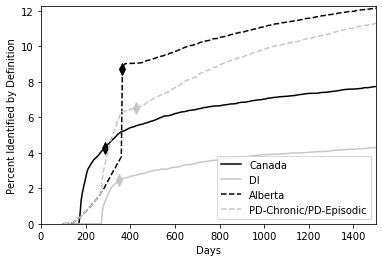

In [68]:
plt.plot(gocX[0:-1],gocCdf,'-',color='black',label='Canada')
plt.plot(gocX[gocMedIdx],gocCdf[gocMedIdx],'d',color='black',markersize=8)

plt.plot(diX[0:-1],diCdf,'-',color='#c7c7c7',label='DI')
plt.plot(diX[diMedIdx],diCdf[diMedIdx],'d',color='#c7c7c7',markersize=8)

plt.plot(goaX[0:-1],goaCdf,'--',color='black',label='Alberta')
plt.plot(goaX[goaMedIdx],goaCdf[goaMedIdx],'d',color='black',markersize=8)

plt.plot(prgX[0:-1],prgCdf,'--',color='#c7c7c7',label='PD-Chronic/PD-Episodic')
plt.plot(prgX[prgMedIdx],prgCdf[prgMedIdx],'d',color='#c7c7c7',markersize=8)

plt.legend()
plt.xlim(0,1500)
plt.xlabel('Days')
plt.ylim(0,12.25)
plt.ylabel('Percent Identified by Definition')
#plt.savefig('SpeedCdf.eps')
plt.show()

In [58]:
print('GoC Median:',gocX[gocMedIdx])

GoC Median: 285
